Lendo 696 arquivos em 'data\json\cleaned_factors\identified_factors'...
Total de fatores processados: 1641

Top 5 fatores mais comuns:
 - julgamento de pilotagem: 284
 - aplicação do comando: 194
 - planejamento do voo: 162
 - supervisão gerencial: 142
 - manutenção da aeronave: 118
Tabela exportada (CSV): data\plots\ranking_top_fatores.csv
Tabela exportada (Excel): data\plots\ranking_top_fatores.xlsx
Gráfico de barras salvo em: data\plots\ranking_fatores.png


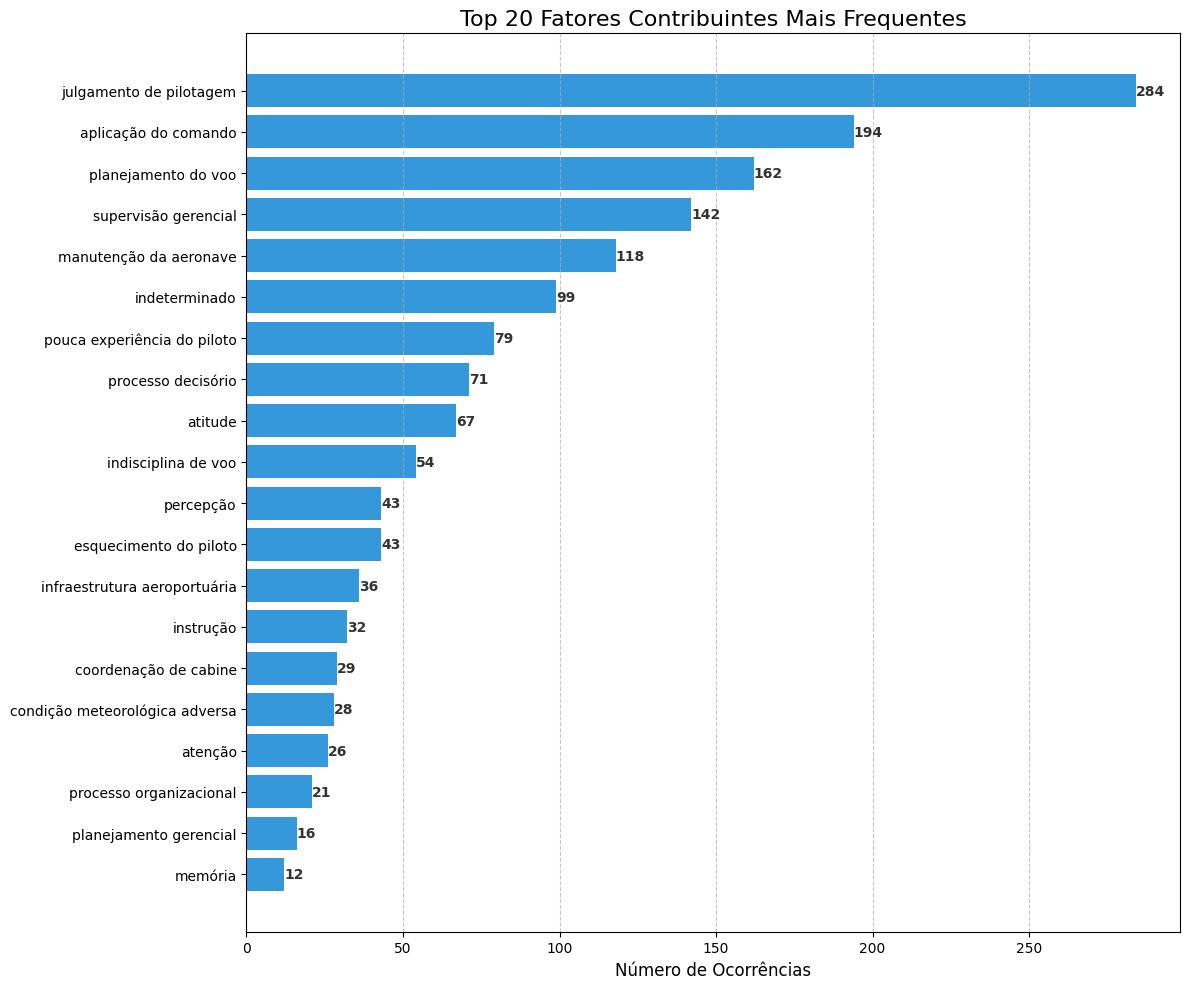


Gerando tabela completa de todos os fatores...
Tabela exportada (CSV): data\plots\todos_fatores_consolidado.csv
Tabela exportada (Excel): data\plots\todos_fatores_consolidado.xlsx
Nuvem de palavras salva em: data\plots\nuvem_palavras.png


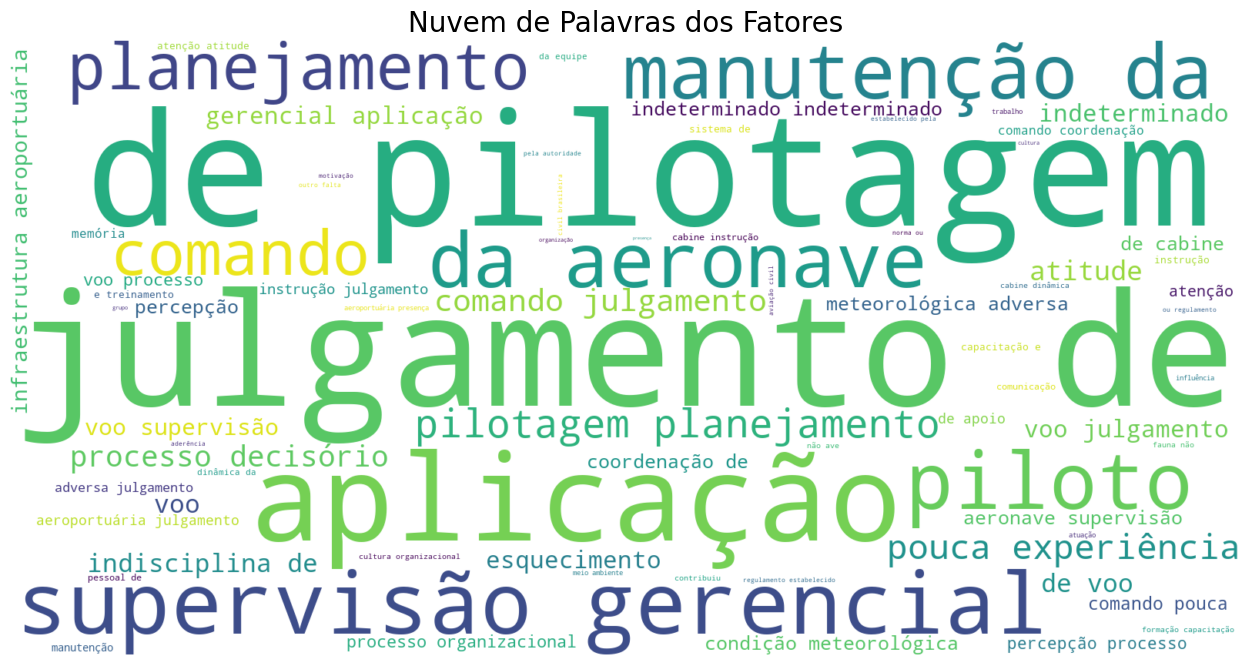

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

# ==============================================================================
# CONFIGURAÇÕES
# ==============================================================================
# Caminho atualizado conforme sua indicação ("identified_factors")
INPUT_DIR = Path('data/json/cleaned_factors/identified_factors')
OUTPUT_IMG_DIR = Path('data/plots')

# Quantos itens mostrar no gráfico de barras (Top N)
TOP_N = 20

def carregar_dados():
    """Lê todos os JSONs e retorna uma lista bruta com todos os fatores encontrados."""
    if not INPUT_DIR.exists():
        print(f"Erro: Diretório {INPUT_DIR} não encontrado.")
        return []

    todos_fatores = []
    arquivos = list(INPUT_DIR.glob("*.json"))

    print(f"Lendo {len(arquivos)} arquivos em '{INPUT_DIR}'...")

    for arquivo in arquivos:
        try:
            with open(arquivo, 'r', encoding='utf-8') as f:
                dados = json.load(f)

            # Navega até a lista de fatores
            if 'conteudo' in dados and 'fatores_contribuintes' in dados['conteudo']:
                lista = dados['conteudo']['fatores_contribuintes']
                # Adiciona os itens da lista ao nosso acumulador geral
                todos_fatores.extend(lista)

        except Exception as e:
            print(f"Erro ao ler {arquivo.name}: {e}")

    return todos_fatores

def exportar_dados(df, nome_arquivo):
    """
    Função auxiliar para exportar DataFrame para CSV e Excel.
    """
    # Exporta para CSV (padrão universal)
    caminho_csv = OUTPUT_IMG_DIR / f'{nome_arquivo}.csv'
    # encoding='utf-8-sig' é crucial para abrir corretamente no Excel com acentos
    df.to_csv(caminho_csv, index=False, sep=';', encoding='utf-8-sig')
    print(f"Tabela exportada (CSV): {caminho_csv}")

    # Tenta exportar para Excel (requer biblioteca openpyxl instalada)
    try:
        caminho_xlsx = OUTPUT_IMG_DIR / f'{nome_arquivo}.xlsx'
        df.to_excel(caminho_xlsx, index=False)
        print(f"Tabela exportada (Excel): {caminho_xlsx}")
    except ImportError:
        print("Aviso: Para exportar em .xlsx, instale: pip install openpyxl")
    except Exception as e:
        print(f"Não foi possível exportar para Excel: {e}")

def plotar_barras_horizontais(counter_obj):
    """Gera gráfico de barras e exporta os dados tabulados."""

    # 1. Prepara os dados do TOP N para o gráfico
    df_top = pd.DataFrame(counter_obj.most_common(TOP_N), columns=['Fator', 'Ocorrências'])
    df_top = df_top.sort_values(by='Ocorrências', ascending=True)

    # --- EXPORTAÇÃO DOS DADOS DO GRÁFICO ---
    # Exportamos o DataFrame ordenado (decrescente para leitura na tabela)
    df_export = df_top.sort_values(by='Ocorrências', ascending=False)
    exportar_dados(df_export, 'ranking_top_fatores')
    # ---------------------------------------

    plt.figure(figsize=(12, 10))

    # Cria as barras
    plt.barh(df_top['Fator'], df_top['Ocorrências'], color='#3498db')

    # Estilização
    plt.xlabel('Número de Ocorrências', fontsize=12)
    plt.title(f'Top {TOP_N} Fatores Contribuintes Mais Frequentes', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adiciona o valor exato na ponta de cada barra
    for index, value in enumerate(df_top['Ocorrências']):
        plt.text(value, index, str(value), va='center', fontsize=10, fontweight='bold', color='#333333')

    plt.tight_layout()

    # Salva imagem
    caminho_arquivo = OUTPUT_IMG_DIR / 'ranking_fatores.png'
    plt.savefig(caminho_arquivo, dpi=300)
    print(f"Gráfico de barras salvo em: {caminho_arquivo}")
    plt.show()

def exportar_tabela_completa(counter_obj):
    """Exporta TODOS os dados (não apenas o Top N) para quem quiser ver a cauda longa."""
    print("\nGerando tabela completa de todos os fatores...")
    df_completo = pd.DataFrame(counter_obj.most_common(), columns=['Fator', 'Ocorrências'])
    exportar_dados(df_completo, 'todos_fatores_consolidado')

def plotar_nuvem_palavras(todos_fatores):
    """Sugestão Extra: Gera uma WordCloud."""
    try:
        from wordcloud import WordCloud
    except ImportError:
        print("\n[Aviso] Biblioteca 'wordcloud' não instalada. Pulei a geração da nuvem.")
        return

    texto_completo = " ".join(todos_fatores)
    wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='viridis').generate(texto_completo)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras dos Fatores', fontsize=20)

    caminho_arquivo = OUTPUT_IMG_DIR / 'nuvem_palavras.png'
    plt.savefig(caminho_arquivo, dpi=300)
    print(f"Nuvem de palavras salva em: {caminho_arquivo}")
    plt.show()

def main():
    OUTPUT_IMG_DIR.mkdir(parents=True, exist_ok=True)

    # 1. Coleta
    dados = carregar_dados()
    if not dados:
        print("Nenhum dado encontrado.")
        return

    print(f"Total de fatores processados: {len(dados)}")

    # 2. Contagem
    contagem = Counter(dados)

    # Mostra prévia no console
    print("\nTop 5 fatores mais comuns:")
    for fator, qtd in contagem.most_common(5):
        print(f" - {fator}: {qtd}")

    # 3. Plotagem e Exportação do Top N
    plotar_barras_horizontais(contagem)

    # 4. Exportação Completa (Opcional, mas útil)
    exportar_tabela_completa(contagem)

    # 5. Plotagem (Nuvem de Palavras)
    plotar_nuvem_palavras(dados)

if __name__ == "__main__":
    main()